# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
assert torch.cuda.is_available()
import math
from glob import glob
from torchvision.ops import nms
# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
timm.list_models();



def check_excess_coordinates(file_path):
    """
    Check if the XML file contains more than x5 y5 coordinates.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bndbox = obj.find('polygon')
        if bndbox is not None:
            coordinates = [child.tag for child in bndbox]
            # Checking if there are more than 10 tags (x1, y1, ..., x5, y5)
            if len(coordinates) > 10:
                return True
    return False

def main(folder_path):
    """
    Scan through all XML files in the folder and list those to be deleted.
    """
    files_to_delete = []
    for file in os.listdir(folder_path):
        if file.endswith('.xml'):
            file_path = os.path.join(folder_path, file)
            if check_excess_coordinates(file_path):
                files_to_delete.append(file_path)

    return files_to_delete

# Usage example (replace 'path_to_your_folder' with the actual folder path)
files_to_delete = main('C:/Users/John/Desktop/notebooks/datasets/number-license-plate.v5i.voc/train')
print("Files to delete:", files_to_delete)

# Optional: Uncomment the following lines to actually delete the files
for file_path in files_to_delete:
    os.remove(file_path)
    os.remove(file_path.replace(".xml",".jpg"))


In [3]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 512 
input_height = 512

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 4 #32 #16 #4

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2#24

In [4]:
def extract_coordinates(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    all_objects_coords = []
    all_names = []
    for obj in root.findall('object'):
        coords = {}

        # Extracting coordinates from bndbox
        bndbox = obj.find('bndbox')
        name = obj.find('name').text
        if bndbox is not None:
            coords['xmin'] = bndbox.find('xmin').text if bndbox.find('xmin') is not None else None
            coords['ymin'] = bndbox.find('ymin').text if bndbox.find('ymin') is not None else None
            coords['xmax'] = bndbox.find('xmax').text if bndbox.find('xmax') is not None else None
            coords['ymax'] = bndbox.find('ymax').text if bndbox.find('ymax') is not None else None

        # Extracting coordinates from polygon
        # polygon = obj.find('polygon')
        # if polygon is not None:
        #     for i in range(1, 5):
        #         x_tag, y_tag = f'x{i}', f'y{i}'
        #         coords[x_tag] = polygon.find(x_tag).text if polygon.find(x_tag) is not None else None
        #         coords[y_tag] = polygon.find(y_tag).text if polygon.find(y_tag) is not None else None

        all_objects_coords.append(coords)
        all_names.append(name)

    return [all_objects_coords,all_names]

In [5]:
def extract_mask(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract image size from the XML
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)
    
    # Initialize a blank image for the mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Process each object in the XML
    for obj in root.findall('object'):
        # Get the polygon points for the object
        polygon_points = []
        indeks = 0
        temp_poly = []
        for point in obj.find('polygon'):
            indeks += 1;
            temp_poly.append(int(float(point.text.split(' ')[0])))
            if indeks % 2 == 0:
                
            #x = float(point.text.split(' ')[0])
            #y = float(point.text.split(' ')[1])
                polygon_points.append([b for b in temp_poly])
                temp_poly.clear()
                indeks = 0
        
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [np.array(polygon_points, np.int32)], 255)
    return mask

In [6]:
def sort_coordinates(coord_dict):
    # Extracting the coordinates into a list of tuples
    coords = [(float(coord_dict[f'x{i}']), float(coord_dict[f'y{i}'])) for i in range(1, 5)]
    # Sorting the coordinates based on x and then y values
    sort_y = sorted(coords, key=lambda coord: coord[1])
    lowest_2_ymin = sort_y[:2]
    top_left,top_right = sorted(lowest_2_ymin, key=lambda coord: coord[0])
    highest_ymax = sort_y[2:]
    bottom_left,bottom_right = sorted(highest_ymax, key=lambda coord: coord[0])

    return {
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    }

In [18]:
def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.9):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


In [19]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [20]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores


def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm


# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


In [21]:
def scatter_gaussian_kernel(heatmap, bbox_icx, bbox_icy, bbox_w, bbox_h, alpha=0.54):
    eps = 1e-6
    
    heatmap_h, heatmap_w = heatmap.shape
    dtype = heatmap.dtype
    
    area_scale = ((bbox_w * bbox_h) ** 0.2)  # Adjust the exponent for finer control
    std_w = alpha * bbox_w / 6. * area_scale
    std_h = alpha * bbox_h / 6. * area_scale
    
    var_w = std_w ** 2
    var_h = std_h ** 2
    var_w = var_w + eps
    var_h = var_h + eps
    grid_x, grid_y = np.meshgrid(np.arange(heatmap_w, dtype=dtype), np.arange(heatmap_h, dtype=dtype))

    gaussian_kernel = np.exp(-((grid_x - bbox_icx)**2/(2. * var_w))-((grid_y - bbox_icy)**2/(2. * var_h)))
    gaussian_kernel[bbox_icy, bbox_icx] = 1.
    heatmap = np.maximum(heatmap, gaussian_kernel)
    return heatmap

In [22]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
folder = '/home/rivian/Desktop/Datasets/BoxesConv/train_images'
xml_files = glob(folder+'/*.xml')
classes = []
for i in xml_files:
    target = extract_coordinates(i)
    for b in target[1]:
        if b  not in classes:
            classes.append(b)

def make_hm_offset_regr_angle(path):
    hm = np.zeros([len(classes),input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    hm_all = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    
    #corners = np.zeros([8, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    try:
        target = extract_coordinates(path)
        mask = extract_mask(path)
        mask = mask.astype(np.float32) / 255.0
        mask = cv2.resize(mask,(input_width//MODEL_SCALE,input_height//MODEL_SCALE))
    except Exception as e:
        print(e)
        mask = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
        return hm, offset, regr , hm_all,mask
    if len(target[0]) == 0:
        return hm, offset, regr , hm_all,mask
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    
    for (c,n) in zip(target[0],target[1]):
        name = n
        xmin = float(c['xmin']) * (input_width / 1280)
        ymin = float(c['ymin']) * (input_height / 720)
        xmax = float(c['xmax']) * (input_width / 1280)
        ymax =  float(c['ymax']) * (input_height / 720)
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        w = (xmax - xmin)
        h = (ymax - ymin)
#         sorted_coords = sort_coordinates(c)
#         top_left = float(sorted_coords['top_left'][0]) * (input_width / 640) ,float(sorted_coords['top_left'][1]) * (input_height / 640)
#         top_right = float(sorted_coords['top_right'][0]) * (input_width / 640) ,float(sorted_coords['top_right'][1]) * (input_height / 640) 
#         bottom_left = float(sorted_coords['bottom_left'][0])* (input_width / 640) ,float(sorted_coords['bottom_left'][1]) * (input_height / 640) 
#         bottom_right = float(sorted_coords['bottom_right'][0]) * (input_width / 640) ,float(sorted_coords['bottom_right'][1]) * (input_height / 640)
        
        cls = list(classes).index(name)

        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        diameter = 2 * radius + 1
        sigma = diameter / 6


        draw_umich_gaussian(hm[cls], [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)],radius)
        # hm[cls] = draw_msra_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
        #                         sigma=sigma)
        #hm[cls] = scatter_gaussian_kernel(hm[cls], int(cx/MODEL_SCALE), int(cy/MODEL_SCALE), int(w/MODEL_SCALE), int(h/MODEL_SCALE))
#         hm_all = draw_msra_gaussian(hm_all, [int(cx/MODEL_SCALE), int(cy/MODEL_SCALE)], 
#                                 sigma=sigma)
        
        assert 0 <= cx < input_width
        assert 0 <= cy < input_height
        offset = draw_offset(offset, cx/MODEL_SCALE, cy/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = w/MODEL_SCALE
                    regr[1, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = h/MODEL_SCALE
                    
#                     corners[0, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_left[0]/MODEL_SCALE
#                     corners[1, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_left[1]/MODEL_SCALE
                    
#                     corners[2, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_right[0]/MODEL_SCALE
#                     corners[3, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = top_right[1]/MODEL_SCALE
                    
#                     corners[4, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_left[0]/MODEL_SCALE
#                     corners[5, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_left[1]/MODEL_SCALE
                    
#                     corners[6, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_right[0]/MODEL_SCALE
#                     corners[7, int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = bottom_right[1]/MODEL_SCALE
                    hm_all[int(cy/MODEL_SCALE)+i, int(cx/MODEL_SCALE)+j] = 1
                    
                    
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, hm_all,mask#,corners


for xml in xml_files:
    hm, offset, regr, hm_all,corners = make_hm_offset_regr_angle(xml)
    img = cv2.imread(xml.replace(".xml",".jpg"))
    img = cv2.resize(img,(128,128))
    plt.title(xml.split("\\")[-1])
    plt.imshow(img)
    plt.imshow(hm[0],alpha=0.5,cmap="jet")
    plt.show()
    

# Make Pytorch dataset with dataloader

In [23]:
# Split train-test by unique image ids, corresponding to image paths
folder = '/home/rivian/Desktop/Datasets/BoxesConv/'


train_id = glob(folder+"train_images/*.jpg") + glob(folder+"train_images/*.png")
val_id = glob(folder+"val_images/*.jpg") + glob(folder+"val_images/*.png")

In [24]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id,val, transform=None):
        self.img_id = img_id
        self.val = val
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.val == True: f_name = "val_images"
        else: f_name = "train_images" 
        #print(self.img_id[idx])
        img = cv2.imread(self.img_id[idx])
        img = cv2.resize(img,(input_width,input_height))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        extension = os.path.splitext(self.img_id[idx])[1]
        hm, offset, regr,hm_all,mask = make_hm_offset_regr_angle(self.img_id[idx].replace(extension,".xml"))
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr,hm_all,mask


In [25]:
traindataset = CarDataset(train_id,val=False)
valdataset = CarDataset(val_id,val=True)


In [26]:
train_id[0]

'/home/rivian/Desktop/Datasets/BoxesConv/train_images/AmsBlack_57_jpg.rf.985e2d6b2b34901f9a3ff78251800fd6.jpg'

In [27]:
classes

['parcel']

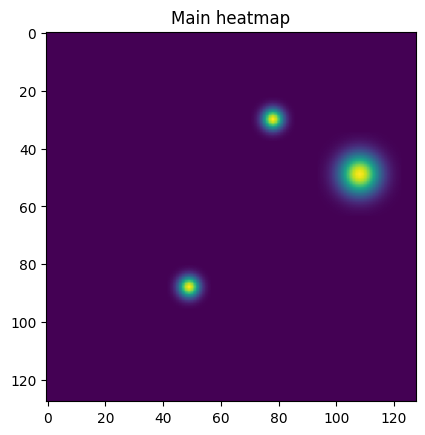

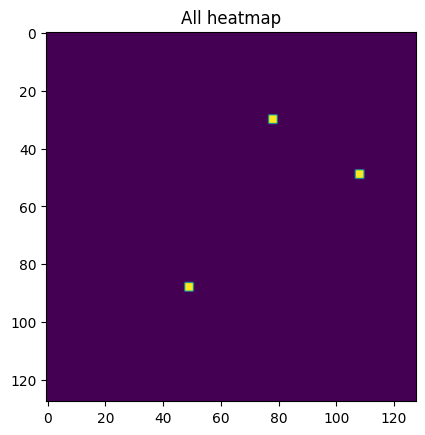

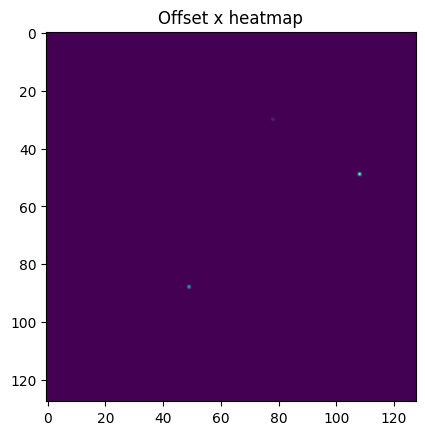

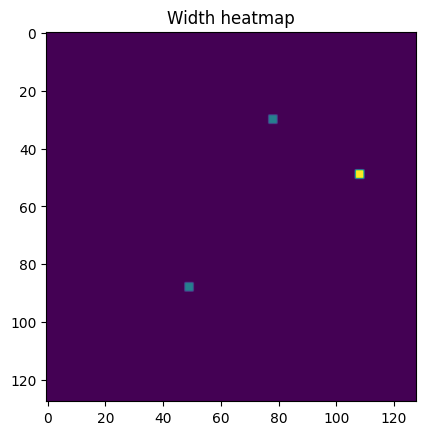

[[14.         30.22222222]
 [32.5        43.02222222]
 [14.2        26.13333333]]
[[14.         32.5        14.2       ]
 [30.22222222 43.02222222 26.13333333]]
[312, 120]
[435, 199]
[198, 353]


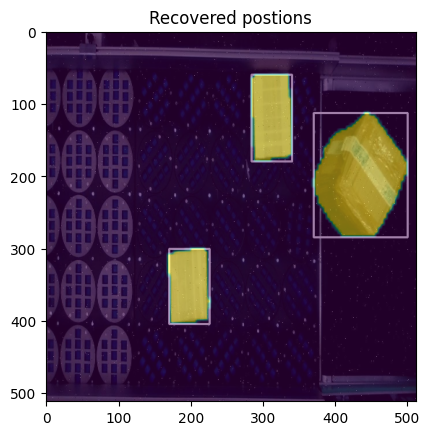

In [28]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr,hm_all,mask = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

# plt.imshow(mask)
# plt.title("Mask")
# plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(train_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.imshow(cv2.resize(mask,(512,512)),alpha=0.5)
plt.title("Recovered postions")
plt.show()

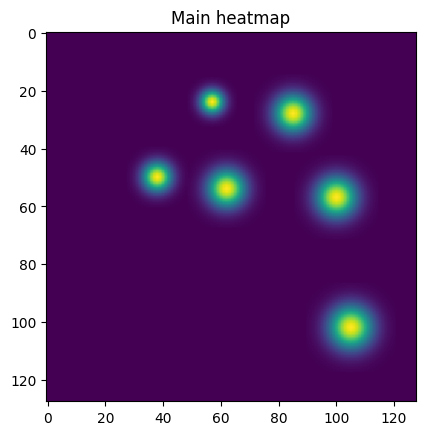

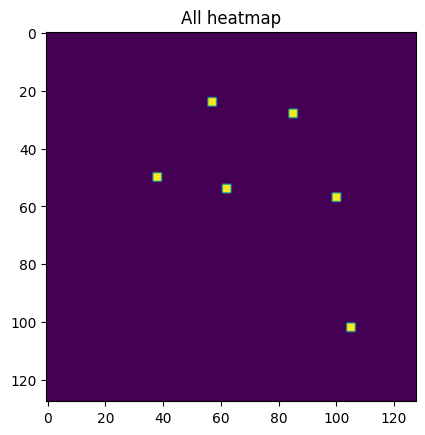

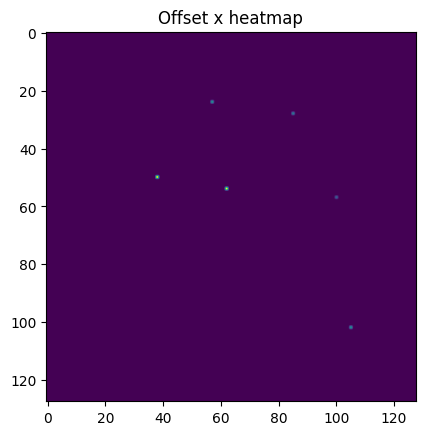

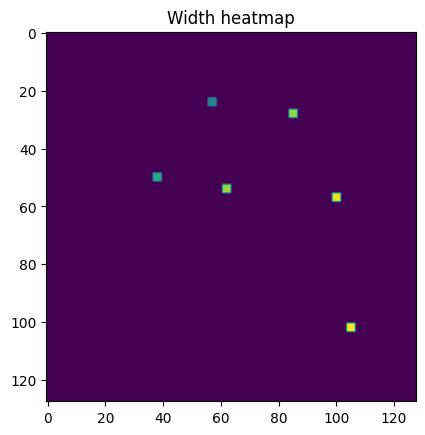

[[15.7        29.33333333]
 [27.4        46.22222222]
 [20.2        37.33333333]
 [27.8        44.44444444]
 [31.5        42.66666667]
 [32.7        50.66666667]]
[[15.7        27.4        20.2        27.8        31.5        32.7       ]
 [29.33333333 46.22222222 37.33333333 44.44444444 42.66666667 50.66666667]]
[229, 97]
[340, 113]
[154, 201]
[250, 216]
[400, 228]
[421, 409]


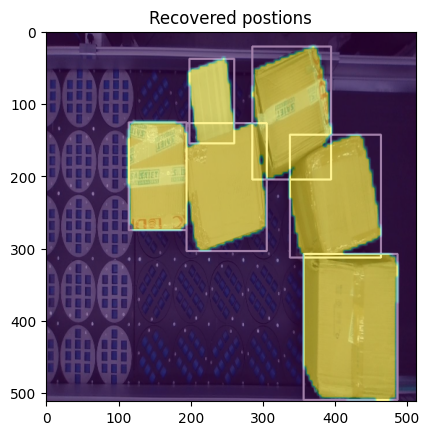

In [29]:
# Check traindataset
k = random.randint(0, len(val_id))
# Test dataset
img, hm, offset, regr,hm_all,mask= valdataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

plt.imshow(mask)
# plt.title("Mask")
# plt.show()

# plt.imshow(corners[0])
# plt.title("Corner heatmap")
# plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(val_id[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.imshow(cv2.resize(mask,(512,512)),alpha=0.5)
plt.title("Recovered postions")
plt.show()

In [30]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False)

In [31]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [32]:
name = 'convnext_atto'
basemodel = timm.create_model(name, features_only=True, pretrained=True)
o = basemodel(torch.rand(1,3,input_width,input_height))
fsize = []
for x in o:
    #print(x.size(2))
    if x.size(3) == input_width // 8:
        #print("Size is 160",x.shape)
        fsize.append(x.size(1))
        
    if x.size(3) == input_width // 16:
        #print("Size is 80",x.shape)
        fsize.append(x.size(1))
    
    if x.size(3) == input_width // 32:
        #print("Size is 40",x.shape)
        fsize.append(x.size(1))
fsize

[80, 160, 320]

In [33]:
for i in o:
    print(i.shape)

torch.Size([1, 40, 128, 128])
torch.Size([1, 80, 64, 64])
torch.Size([1, 160, 32, 32])
torch.Size([1, 320, 16, 16])


In [34]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

In [35]:
def fill_up_weights(up):
    w = up.weight.data
    f = math.ceil(w.size(2) / 2)
    c = (2 * f - 1 - f % 2) / (2. * f)
    for i in range(w.size(2)):
        for j in range(w.size(3)):
            w[:, 0, i, j] = \
                (1 - math.fabs(i / f - c)) * (1 - math.fabs(j / f - c))



class Upsamling(nn.Module):
    def __init__(self, in_channels, out_channels, ksize, stride=2):
        super(Upsamling, self).__init__()
        # deconv basic config
        if ksize == 4:
            padding = 1
            output_padding = 0
        elif ksize == 3:
            padding = 1
            output_padding = 1
        elif ksize == 2:
            padding = 0
            output_padding = 0
        
        self.conv = DeformableConv2d(in_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.up = nn.ConvTranspose2d(out_channels, out_channels, ksize, stride=stride, padding=padding, output_padding=output_padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        fill_up_weights(self.up)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv(x)))
        x = torch.relu(self.bn2(self.up(x)))
        return x
    

## Define Centernet model

In [36]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        #basemodel = timm.create_model('dla34', features_only=True, pretrained=True)
        #torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        num_ch = 256
        head_conv = 64
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = basemodel #nn.Sequential(*list(basemodel.children())[:-3])

        self.low_level = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.upsampler = nn.Upsample(scale_factor=2, mode='nearest') 
        self.mid_level = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.high_level = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fpn_ = torchvision.ops.FeaturePyramidNetwork(fsize, 256)
        self.fixer = nn.Conv2d(fsize[-1], num_ch, kernel_size=3, padding=1)

        
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, len(classes), kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))

        self.outseg = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                #DeformableConv2d(num_ch, head_conv),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
#         self.outa = nn.Sequential(
#                 nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
#                 #DeformableConv2d(num_ch, head_conv),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(head_conv, 8, kernel_size=1, stride=1))

        self.upsample1 = Upsamling(256, 256, ksize=4, stride=2) # 32 -> 16
        self.upsample2 = Upsamling(256, 128, ksize=4, stride=2) # 16 -> 8
        self.upsample3 = Upsamling(128, 256, ksize=4, stride=2) #  8 -> 4
        
        self.downsm = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3,stride=2,padding=1),nn.ReLU())
        
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        o = self.base_model(x)

        # ll_ml_hl = []
        # for x in o:
        #     #print(x.size(2))
        #     if x.size(3) == input_width // 8:
        #         #print("Size is 160",x.shape)
        #         ll_ml_hl.append(x)
                
        #     if x.size(3) == input_width // 16:
        #         #print("Size is 80",x.shape)
        #         ll_ml_hl.append(x)
        
        #     if x.size(3) == input_width // 32:
        #         #print("Size is 40",x.shape)
        #         ll_ml_hl.append(x)

        # low_level = ll_ml_hl[0]
        # mid_level = ll_ml_hl[1]
        # high_level = ll_ml_hl[2]

        # high = self.upsampler(self.high_level(high_level)) #256,80,80
        # mid = self.mid_level(mid_level) + high #256,80,80
        # low = self.upsampler(mid) + self.low_level(low_level) #256,160,160 

        # x_feats = OrderedDict()
        # x_feats['feat0'] = low_level
        # x_feats['feat2'] = mid_level
        # x_feats['feat3'] = high_level

        # x = low
        #fpn_res = self.fpn_(x_feats)
        #x = high_level
        x = o[-1] #fpn_res['feat3']
        x = self.fixer(x)
        
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        
        
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        #outcorner = self.outa(x)

        outseg = self.outseg(x)
        
        return outc, outo, outr,outseg #, outcorner

# Define Loss (Focal loss + L1-loss)

In [37]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #hm_gt = torch.sum(hm_gt,axis=1)

    mask = hm_all.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    #mask_ = mask.expand_as(corner_gt).float()
    mask = mask.expand_as(off_gt).float()
    
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
#     corner_pred = corner_pred * mask_
#     corner_gt = corner_gt * mask_
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #corner_loss =   0.1 * nn.functional.l1_loss(corner_pred, corner_gt, reduction='sum') / (num + 1e-4) 
    
    return off_loss, wh_loss #, corner_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt,hm_all,mask_seg,preds_mask):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.clamp(torch.sigmoid(hm_pred), min=1e-4, max=1-1e-4)
    #print(pred_mask.shape)
    pred_mask = pred_mask.unsqueeze(1).float()
    #print(pred_mask.shape)

    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all)
    
    assert not torch.isnan(off_loss)

    seg_mask = torch.clamp(torch.sigmoid(preds_mask), min=1e-4, max=1-1e-4)
    criterion_seg =  nn.BCELoss()
    loss_seg = criterion_seg(seg_mask,mask_seg.unsqueeze(1))
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss,loss_seg

basemodel = timm.create_model('convnext_nano', features_only=True, pretrained=True)

for i in basemodel(torch.rand(1,3,1280,720)): 
    print(i.shape)
    print(i.size(2))

# Training

In [38]:
"""
hm = torch.tensor(hm_gt)
outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
top_label   = np.array(results[0][:, 5], dtype = 'int32')
top_conf    = results[0][:, 4]
top_boxes   = results[0][:, :4]
print(top_boxes)
for box in top_boxes:
    ymin = box[0]
    xmin = box[1] 
    ymax = box[2] 
    xmax = box[3] 

    xmin = int(xmin)
    ymin = int(ymin)
    xmax = int(xmax)
    ymax = int(ymax)

    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)



"""

"\nhm = torch.tensor(hm_gt)\noutputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())\nresults = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)\ntop_label   = np.array(results[0][:, 5], dtype = 'int32')\ntop_conf    = results[0][:, 4]\ntop_boxes   = results[0][:, :4]\nprint(top_boxes)\nfor box in top_boxes:\n    ymin = box[0]\n    xmin = box[1] \n    ymax = box[2] \n    xmax = box[3] \n\n    xmin = int(xmin)\n    ymin = int(ymin)\n    xmax = int(xmax)\n    ymax = int(ymax)\n\n    cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)\n\n\n\n"

In [39]:
def pool_nms(heat, kernel = 3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep




def decode_bbox(pred_hms, pred_whs, pred_offsets, confidence=0.3, cuda=True):
    #-------------------------------------------------------------------------#
    #   当利用512x512x3图片进行coco数据集预测的时候
    #   h = w = 128 num_classes = 80
    #   Hot map热力图 -> b, 80, 128, 128, 
    #   进行热力图的非极大抑制，利用3x3的卷积对热力图进行最大值筛选
    #   找出一定区域内，得分最大的特征点。
    #-------------------------------------------------------------------------#
    pred_hms = pool_nms(pred_hms)
    
    b, c, output_h, output_w = pred_hms.shape
    detects = []
    #-------------------------------------------------------------------------#
    #   只传入一张图片，循环只进行一次
    #-------------------------------------------------------------------------#
    for batch in range(b):
        #-------------------------------------------------------------------------#
        #   heat_map        128*128, num_classes    热力图
        #   pred_wh         128*128, 2              特征点的预测宽高
        #                                           在预测过程的前处理以及后处理视频中讲的有点小问题，不是调整参数，就是宽高
        #   pred_offset     128*128, 2              特征点的xy轴偏移情况
        #-------------------------------------------------------------------------#
        heat_map    = pred_hms[batch].permute(1, 2, 0).view([-1, c])
        pred_wh     = pred_whs[batch].permute(1, 2, 0).view([-1, 2])
        pred_offset = pred_offsets[batch].permute(1, 2, 0).view([-1, 2])

        yv, xv      = torch.meshgrid(torch.arange(0, output_h), torch.arange(0, output_w))
        #-------------------------------------------------------------------------#
        #   xv              128*128,    特征点的x轴坐标
        #   yv              128*128,    特征点的y轴坐标
        #-------------------------------------------------------------------------#
        xv, yv      = xv.flatten().float(), yv.flatten().float()
        if cuda:
            xv      = xv.cuda()
            yv      = yv.cuda()

        #-------------------------------------------------------------------------#
        #   class_conf      128*128,    特征点的种类置信度
        #   class_pred      128*128,    特征点的种类
        #-------------------------------------------------------------------------#
        class_conf, class_pred  = torch.max(heat_map, dim = -1)
        mask                    = class_conf > confidence

        #-----------------------------------------#
        #   取出得分筛选后对应的结果
        #-----------------------------------------#
        pred_wh_mask        = pred_wh[mask]
        pred_offset_mask    = pred_offset[mask]
        if len(pred_wh_mask) == 0:
            detects.append([])
            continue     

        #----------------------------------------#
        #   计算调整后预测框的中心
        #----------------------------------------#
        xv_mask = torch.unsqueeze(xv[mask] + pred_offset_mask[..., 0], -1)
        yv_mask = torch.unsqueeze(yv[mask] + pred_offset_mask[..., 1], -1)
        #----------------------------------------#
        #   计算预测框的宽高
        #----------------------------------------#
        half_w, half_h = pred_wh_mask[..., 0:1] / 2, pred_wh_mask[..., 1:2] / 2
        #----------------------------------------#
        #   获得预测框的左上角和右下角
        #----------------------------------------#
        bboxes = torch.cat([xv_mask - half_w, yv_mask - half_h, xv_mask + half_w, yv_mask + half_h], dim=1)
        bboxes[:, [0, 2]] /= output_w
        bboxes[:, [1, 3]] /= output_h
        detect = torch.cat([bboxes, torch.unsqueeze(class_conf[mask],-1), torch.unsqueeze(class_pred[mask],-1).float()], dim=-1)
        detects.append(detect)

    return detects

def centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image):
    #-----------------------------------------------------------------#
    #   把y轴放前面是因为方便预测框和图像的宽高进行相乘
    #-----------------------------------------------------------------#
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape)
    image_shape = np.array(image_shape)

    if letterbox_image:
        #-----------------------------------------------------------------#
        #   这里求出来的offset是图像有效区域相对于图像左上角的偏移情况
        #   new_shape指的是宽高缩放情况
        #-----------------------------------------------------------------#
        new_shape = np.round(image_shape * np.min(input_shape/image_shape))
        offset  = (input_shape - new_shape)/2./input_shape
        scale   = input_shape/new_shape

        box_yx  = (box_yx - offset) * scale
        box_hw *= scale

    box_mins    = box_yx - (box_hw / 2.)
    box_maxes   = box_yx + (box_hw / 2.)
    boxes  = np.concatenate([box_mins[..., 0:1], box_mins[..., 1:2], box_maxes[..., 0:1], box_maxes[..., 1:2]], axis=-1)
    boxes *= np.concatenate([image_shape, image_shape], axis=-1)
    return boxes

def postprocess(prediction, need_nms, image_shape, input_shape, letterbox_image, nms_thres=0.4):
    output = [None for _ in range(len(prediction))]
    
    #----------------------------------------------------------#
    #   预测只用一张图片，只会进行一次
    #----------------------------------------------------------#
    for i, image_pred in enumerate(prediction):
        detections      = prediction[i]
        if len(detections) == 0:
            continue
        #------------------------------------------#
        #   获得预测结果中包含的所有种类
        #------------------------------------------#
        unique_labels   = detections[:, -1].cpu().unique()

        if detections.is_cuda:
            unique_labels = unique_labels.cuda()
            detections = detections.cuda()

        for c in unique_labels:
            #------------------------------------------#
            #   获得某一类得分筛选后全部的预测结果
            #------------------------------------------#
            detections_class = detections[detections[:, -1] == c]
            if need_nms:
                #------------------------------------------#
                #   使用官方自带的非极大抑制会速度更快一些！
                #------------------------------------------#
                keep = nms(
                    detections_class[:, :4],
                    detections_class[:, 4],
                    nms_thres
                )
                max_detections = detections_class[keep]

                # #------------------------------------------#
                # #   按照存在物体的置信度排序
                # #------------------------------------------#
                # _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
                # detections_class = detections_class[conf_sort_index]
                # #------------------------------------------#
                # #   进行非极大抑制
                # #------------------------------------------#
                # max_detections = []
                # while detections_class.size(0):
                #     #---------------------------------------------------#
                #     #   取出这一类置信度最高的，一步一步往下判断。
                #     #   判断重合程度是否大于nms_thres，如果是则去除掉
                #     #---------------------------------------------------#
                #     max_detections.append(detections_class[0].unsqueeze(0))
                #     if len(detections_class) == 1:
                #         break
                #     ious = bbox_iou(max_detections[-1], detections_class[1:])
                #     detections_class = detections_class[1:][ious < nms_thres]
                # #------------------------------------------#
                # #   堆叠
                # #------------------------------------------#
                # max_detections = torch.cat(max_detections).data
            else:
                max_detections  = detections_class
            
            output[i] = max_detections if output[i] is None else torch.cat((output[i], max_detections))

        if output[i] is not None:
            output[i]           = output[i].cpu().numpy()
            box_xy, box_wh      = (output[i][:, 0:2] + output[i][:, 2:4])/2, output[i][:, 2:4] - output[i][:, 0:2]
            output[i][:, :4]    = centernet_correct_boxes(box_xy, box_wh, input_shape, image_shape, letterbox_image)
    return output

t = tqdm(train_loader)
device = "cuda"
for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        image_shape = [512,512]
        for t in range(len(img)):
            sample = img[t].cpu().permute(1,2,0).numpy().copy()
            hm = torch.tensor(hm_gt[t])
            #hm = torch.sigmoid(hm)
            outputs = decode_bbox(hm[None].cuda(),torch.tensor(wh_gt[t][None]).cuda(),torch.tensor(offset_gt[t][None]).cuda())
            results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
            top_label   = np.array(results[0][:, 5], dtype = 'int32')
            top_conf    = results[0][:, 4]
            top_boxes   = results[0][:, :4]
            #print(top_boxes)
            for box in top_boxes:
                ymin = box[0]
                xmin = box[1] 
                ymax = box[2] 
                xmax = box[3] 

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                #print(xmin,ymin,xmax,ymax)
                cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
            plt.imshow(sample)
            plt.show()
            #break

In [40]:
from mean_average_precision import MetricBuilder

In [41]:
"""
# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
gt = np.array([
    [439, 157, 556, 241, 0, 0, 0],
    [437, 246, 518, 351, 0, 0, 0],
    [515, 306, 595, 375, 0, 0, 0],
    [407, 386, 531, 476, 0, 0, 0],
    [544, 419, 621, 476, 0, 0, 0],
    [609, 297, 636, 392, 0, 0, 0]
])

# [xmin, ymin, xmax, ymax, class_id, confidence]
preds = np.array([
    [429, 219, 528, 247, 0, 0.460851],
    [433, 260, 506, 336, 0, 0.269833],
    [518, 314, 603, 369, 0, 0.462608],
    [592, 310, 634, 388, 0, 0.298196],
    [403, 384, 517, 461, 0, 0.382881],
    [405, 429, 519, 470, 0, 0.369369],
    [433, 272, 499, 341, 0, 0.272826],
    [413, 390, 515, 459, 0, 0.619459]
])


"""

'\n# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]\ngt = np.array([\n    [439, 157, 556, 241, 0, 0, 0],\n    [437, 246, 518, 351, 0, 0, 0],\n    [515, 306, 595, 375, 0, 0, 0],\n    [407, 386, 531, 476, 0, 0, 0],\n    [544, 419, 621, 476, 0, 0, 0],\n    [609, 297, 636, 392, 0, 0, 0]\n])\n\n# [xmin, ymin, xmax, ymax, class_id, confidence]\npreds = np.array([\n    [429, 219, 528, 247, 0, 0.460851],\n    [433, 260, 506, 336, 0, 0.269833],\n    [518, 314, 603, 369, 0, 0.462608],\n    [592, 310, 634, 388, 0, 0.298196],\n    [403, 384, 517, 461, 0, 0.382881],\n    [405, 429, 519, 470, 0, 0.369369],\n    [433, 272, 499, 341, 0, 0.272826],\n    [413, 390, 515, 459, 0, 0.619459]\n])\n\n\n'

In [42]:
classes

['parcel']

In [43]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=len(classes))

In [44]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    train_seg_loss = 0.0
    #train_corner_loss = 0.0
    #train_angle_loss = 0.0
    use_amp = True
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    for idx, (img, hm, offset, regr,hm_all,mask) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        mask = mask.to(device)
        #corner_gt = corner.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
        preds_hm, preds_offset, preds_wh, preds_mask = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])

        foc_loss, pos_loss, neg_loss, off_loss, wh_loss , loss_seg = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all,mask,preds_mask)
        loss = foc_loss + off_loss + wh_loss + loss_seg

        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        train_seg_loss += float(loss_seg)
        #train_corner_loss += float(corner_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        #optimizer.zero_grad() # set_to_none=True here can modestly improve performance
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    val_seg_loss = 0.0
    #val_corner_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr,hm_all,mask) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            hm_all = hm_all.to(device)
            mask = mask.to(device)
            #corner_gt = corner.to(device)
            #angle_gt = angle.to(device)

            # run model
            #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            preds_hm, preds_offset, preds_wh,preds_mask = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss,loss_seg = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all,mask,preds_mask)

            loss = foc_loss + off_loss + wh_loss + loss_seg
            
            """gt"""
            gts = []
            image_shape = [512,512]
            for t in range(len(img)):
                sample = img[t].cpu().permute(1,2,0).numpy().copy()
                hm = hm_gt[t]
                outputs = decode_bbox(hm[None].cuda(),wh_gt[t][None].cuda(),offset_gt[t][None].cuda())
                results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
                if results is not None and len(results) > 0:
                    try:
                        top_label   = np.array(results[0][:, 5], dtype = 'int32')
                        top_conf    = results[0][:, 4]
                        top_boxes   = results[0][:, :4]

                        for (conf,label,box) in zip(top_conf,top_label,top_boxes):
                            ymin = box[0]
                            xmin = box[1] 
                            ymax = box[2] 
                            xmax = box[3] 

                            xmin = int(xmin)
                            ymin = int(ymin)
                            xmax = int(xmax)
                            ymax = int(ymax)
                            class_label = label

                            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
                            cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            row = [xmin, ymin, xmax, ymax, label, 0, 0]
                            gts.append(row)
                    except:
                        pass
                
                    
                    
                    
                #plt.title("gt")
                #plt.imshow(sample)
                #plt.show()
                
            """pred"""
            
            preds = []
            for t in range(len(img)):
                sample = img[t].cpu().permute(1,2,0).numpy().copy()
                hm = preds_hm[t]
                hm = torch.sigmoid(hm)
                outputs = decode_bbox(hm[None].cuda(),preds_wh[t][None].cuda(),preds_offset[t][None].cuda())
                results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
                if results is not None and len(results) > 0:
                    try:
                        top_label   = np.array(results[0][:, 5], dtype = 'int32')
                        top_conf    = results[0][:, 4]
                        top_boxes   = results[0][:, :4]

                        for (conf,label,box) in zip(top_conf,top_label,top_boxes):
                            ymin = box[0]
                            xmin = box[1] 
                            ymax = box[2] 
                            xmax = box[3] 

                            xmin = int(xmin)
                            ymin = int(ymin)
                            xmax = int(xmax)
                            ymax = int(ymax)
                            class_label = label

                            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
                            cv2.putText(img = sample,text = f"{classes[class_label]}",org = (xmin,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )
                            cv2.putText(img = sample,text = f"{conf:2f}",org = (xmax,ymin-5),
                            fontFace = cv2.FONT_HERSHEY_DUPLEX,fontScale = 0.8,color = (255, 255, 255),
                            thickness = 1
                            )

                            row = [xmin, ymin, xmax, ymax,label,conf]
                            preds.append(row)
                    except:
                        pass
                    
                    
#                 plt.title("pred")
#                 plt.imshow(sample)
                
#                 plt.show()
                
            preds = np.array(preds)
            gts = np.array(gts)
            metric_fn.add(preds, gts)
                
            
            
            
            
            
            
            
            
            
            
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            val_seg_loss += float(loss_seg)
            #val_corner_loss += float(corner_loss)
            
    mAP = metric_fn.value(iou_thresholds=0.5)['mAP']
            
    print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    print(f'Seg loss : {train_seg_loss/len(train_loader):.4f}')
    #print(f'Corner loss : {train_corner_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    print(f'Val Seg loss : {val_seg_loss/len(val_loader):.4f}')
    #print(f'Val Corner loss : {val_corner_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader),
                 'mAP @0.5':mAP}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader),mAP

In [45]:
#model = CenterNet_Resnet50(len(classes), pretrained = True)
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))
#model.load_state_dict(torch.load(f"centernet-xml-seg-{name}.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')
best_mean_AP = 0

In [46]:
img, hm, offset, regr,hm_all,msk = next(iter(train_loader))

In [47]:
hm.shape 

torch.Size([2, 1, 128, 128])

In [48]:
img.shape

torch.Size([2, 3, 512, 512])

In [49]:
epochs = 15 * 6 * 2 
use_amp = True
device = 'cuda'
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
for epoch in range(epochs):
    val_loss,mean_AP = train(epoch)
    torch.save(model.state_dict(), f"centernet-xml-seg-box-{name}_last.pth")  
    #scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        #torch.save(model.state_dict(), f"centernet-xml-{name}.pth")   
    if mean_AP > best_mean_AP:
        best_mean_AP = mean_AP
        print(f"Improved validation mAP to {best_mean_AP:.3f}")
        torch.save(model.state_dict(), f"centernet-xml-seg-box-{name}.pth")

epochs 1/180
Learning rate : 0.0001


(l=96.77) (pos=3.814) (neg=87.542) (off=0.141) (wh=4.795): 100%|█| 104/104 [00:5
  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/rivian/anaconda3/envs/dl/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 96.7672
Pos loss : 3.8138
Neg loss : 87.5422
Off loss : 0.1412
Wh loss : 4.7946
Seg loss : 0.4754

Val loss : 11.4343
Val Pos loss : 3.4755
Val Neg loss : 2.9225
Val Off loss : 0.1190
Val Wh loss : 4.4235
Val Seg loss : 0.4939
Improved validation loss to 11.434
epochs 2/180
Learning rate : 0.0001


(l=9.08) (pos=2.680) (neg=1.959) (off=0.113) (wh=3.863): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 9.0776
Pos loss : 2.6803
Neg loss : 1.9586
Off loss : 0.1134
Wh loss : 3.8626
Seg loss : 0.4626

Val loss : 7.9481
Val Pos loss : 2.3052
Val Neg loss : 1.4241
Val Off loss : 0.1117
Val Wh loss : 3.6181
Val Seg loss : 0.4890
Improved validation loss to 7.948
epochs 3/180
Learning rate : 0.0001


(l=6.00) (pos=2.158) (neg=1.180) (off=0.112) (wh=2.103): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.05it/s]


VOC PASCAL mAP in all points: 0.0
train loss : 5.9992
Pos loss : 2.1575
Neg loss : 1.1797
Off loss : 0.1116
Wh loss : 2.1028
Seg loss : 0.4476

Val loss : 4.3796
Val Pos loss : 2.1357
Val Neg loss : 0.7586
Val Off loss : 0.1169
Val Wh loss : 0.9165
Val Seg loss : 0.4519
Improved validation loss to 4.380
epochs 4/180
Learning rate : 0.0001


(l=3.48) (pos=1.240) (neg=0.819) (off=0.111) (wh=0.905): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


VOC PASCAL mAP in all points: 0.2299596071243286
train loss : 3.4775
Pos loss : 1.2398
Neg loss : 0.8192
Off loss : 0.1110
Wh loss : 0.9050
Seg loss : 0.4026

Val loss : 2.7645
Val Pos loss : 0.9643
Val Neg loss : 0.4265
Val Off loss : 0.1118
Val Wh loss : 0.8525
Val Seg loss : 0.4095
Improved validation loss to 2.764
Improved validation mAP to 0.230
epochs 5/180
Learning rate : 0.0001


(l=2.35) (pos=0.673) (neg=0.558) (off=0.109) (wh=0.701): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.76it/s]


VOC PASCAL mAP in all points: 0.37212052941322327
train loss : 2.3537
Pos loss : 0.6732
Neg loss : 0.5580
Off loss : 0.1087
Wh loss : 0.7010
Seg loss : 0.3127

Val loss : 1.8180
Val Pos loss : 0.6016
Val Neg loss : 0.3454
Val Off loss : 0.1095
Val Wh loss : 0.5011
Val Seg loss : 0.2604
Improved validation loss to 1.818
Improved validation mAP to 0.372
epochs 6/180
Learning rate : 0.0001


(l=1.72) (pos=0.401) (neg=0.392) (off=0.109) (wh=0.603): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.76it/s]


VOC PASCAL mAP in all points: 0.4676593840122223
train loss : 1.7196
Pos loss : 0.4007
Neg loss : 0.3920
Off loss : 0.1085
Wh loss : 0.6032
Seg loss : 0.2151

Val loss : 1.7071
Val Pos loss : 0.5946
Val Neg loss : 0.2822
Val Off loss : 0.1091
Val Wh loss : 0.5178
Val Seg loss : 0.2033
Improved validation loss to 1.707
Improved validation mAP to 0.468
epochs 7/180
Learning rate : 0.0001


(l=1.46) (pos=0.284) (neg=0.303) (off=0.111) (wh=0.599): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


VOC PASCAL mAP in all points: 0.5349053144454956
train loss : 1.4604
Pos loss : 0.2841
Neg loss : 0.3031
Off loss : 0.1106
Wh loss : 0.5989
Seg loss : 0.1636

Val loss : 1.5701
Val Pos loss : 0.4822
Val Neg loss : 0.3488
Val Off loss : 0.1100
Val Wh loss : 0.4977
Val Seg loss : 0.1314
Improved validation loss to 1.570
Improved validation mAP to 0.535
epochs 8/180
Learning rate : 0.0001


(l=1.22) (pos=0.195) (neg=0.244) (off=0.109) (wh=0.544): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]


VOC PASCAL mAP in all points: 0.5849688649177551
train loss : 1.2199
Pos loss : 0.1954
Neg loss : 0.2445
Off loss : 0.1090
Wh loss : 0.5441
Seg loss : 0.1270

Val loss : 1.4916
Val Pos loss : 0.5073
Val Neg loss : 0.1750
Val Off loss : 0.1105
Val Wh loss : 0.5623
Val Seg loss : 0.1365
Improved validation loss to 1.492
Improved validation mAP to 0.585
epochs 9/180
Learning rate : 0.0001


(l=1.11) (pos=0.168) (neg=0.211) (off=0.108) (wh=0.514): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.75it/s]


VOC PASCAL mAP in all points: 0.6244705319404602
train loss : 1.1113
Pos loss : 0.1682
Neg loss : 0.2108
Off loss : 0.1083
Wh loss : 0.5135
Seg loss : 0.1104

Val loss : 1.1885
Val Pos loss : 0.2719
Val Neg loss : 0.2566
Val Off loss : 0.1089
Val Wh loss : 0.4617
Val Seg loss : 0.0894
Improved validation loss to 1.189
Improved validation mAP to 0.624
epochs 10/180
Learning rate : 0.0001


(l=0.94) (pos=0.106) (neg=0.160) (off=0.107) (wh=0.473): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.70it/s]


VOC PASCAL mAP in all points: 0.6546998620033264
train loss : 0.9435
Pos loss : 0.1057
Neg loss : 0.1604
Off loss : 0.1073
Wh loss : 0.4730
Seg loss : 0.0970

Val loss : 1.0468
Val Pos loss : 0.2073
Val Neg loss : 0.1941
Val Off loss : 0.1088
Val Wh loss : 0.4684
Val Seg loss : 0.0682
Improved validation loss to 1.047
Improved validation mAP to 0.655
epochs 11/180
Learning rate : 0.0001


(l=0.91) (pos=0.084) (neg=0.129) (off=0.108) (wh=0.502): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


VOC PASCAL mAP in all points: 0.6821792721748352
train loss : 0.9075
Pos loss : 0.0841
Neg loss : 0.1293
Off loss : 0.1076
Wh loss : 0.5022
Seg loss : 0.0844

Val loss : 1.1453
Val Pos loss : 0.2791
Val Neg loss : 0.1690
Val Off loss : 0.1085
Val Wh loss : 0.5133
Val Seg loss : 0.0754
Improved validation mAP to 0.682
epochs 12/180
Learning rate : 0.0001


(l=0.74) (pos=0.055) (neg=0.111) (off=0.106) (wh=0.401): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


VOC PASCAL mAP in all points: 0.7044196128845215
train loss : 0.7430
Pos loss : 0.0549
Neg loss : 0.1114
Off loss : 0.1062
Wh loss : 0.4012
Seg loss : 0.0693

Val loss : 1.1733
Val Pos loss : 0.3342
Val Neg loss : 0.1328
Val Off loss : 0.1079
Val Wh loss : 0.5358
Val Seg loss : 0.0627
Improved validation mAP to 0.704
epochs 13/180
Learning rate : 0.0001


(l=0.77) (pos=0.054) (neg=0.103) (off=0.107) (wh=0.435): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.70it/s]


VOC PASCAL mAP in all points: 0.7251959443092346
train loss : 0.7654
Pos loss : 0.0538
Neg loss : 0.1030
Off loss : 0.1066
Wh loss : 0.4353
Seg loss : 0.0668

Val loss : 1.1707
Val Pos loss : 0.3757
Val Neg loss : 0.1311
Val Off loss : 0.1082
Val Wh loss : 0.4919
Val Seg loss : 0.0639
Improved validation mAP to 0.725
epochs 14/180
Learning rate : 0.0001


(l=0.67) (pos=0.045) (neg=0.095) (off=0.106) (wh=0.361): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]


VOC PASCAL mAP in all points: 0.7443570494651794
train loss : 0.6665
Pos loss : 0.0448
Neg loss : 0.0945
Off loss : 0.1059
Wh loss : 0.3614
Seg loss : 0.0599

Val loss : 0.9776
Val Pos loss : 0.2208
Val Neg loss : 0.1613
Val Off loss : 0.1081
Val Wh loss : 0.4213
Val Seg loss : 0.0662
Improved validation loss to 0.978
Improved validation mAP to 0.744
epochs 15/180
Learning rate : 0.0001


(l=0.74) (pos=0.058) (neg=0.100) (off=0.107) (wh=0.413): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.70it/s]


VOC PASCAL mAP in all points: 0.7591390013694763
train loss : 0.7402
Pos loss : 0.0576
Neg loss : 0.0995
Off loss : 0.1071
Wh loss : 0.4126
Seg loss : 0.0634

Val loss : 1.0497
Val Pos loss : 0.2609
Val Neg loss : 0.1652
Val Off loss : 0.1084
Val Wh loss : 0.4526
Val Seg loss : 0.0626
Improved validation mAP to 0.759
epochs 16/180
Learning rate : 0.0001


(l=0.62) (pos=0.046) (neg=0.091) (off=0.106) (wh=0.321): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


VOC PASCAL mAP in all points: 0.7737560272216797
train loss : 0.6194
Pos loss : 0.0461
Neg loss : 0.0914
Off loss : 0.1061
Wh loss : 0.3207
Seg loss : 0.0551

Val loss : 0.9691
Val Pos loss : 0.2294
Val Neg loss : 0.1617
Val Off loss : 0.1078
Val Wh loss : 0.4165
Val Seg loss : 0.0538
Improved validation loss to 0.969
Improved validation mAP to 0.774
epochs 17/180
Learning rate : 0.0001


(l=0.60) (pos=0.045) (neg=0.094) (off=0.106) (wh=0.308): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s]


VOC PASCAL mAP in all points: 0.7860531806945801
train loss : 0.6030
Pos loss : 0.0448
Neg loss : 0.0944
Off loss : 0.1058
Wh loss : 0.3077
Seg loss : 0.0504

Val loss : 0.9817
Val Pos loss : 0.3214
Val Neg loss : 0.1236
Val Off loss : 0.1079
Val Wh loss : 0.3720
Val Seg loss : 0.0569
Improved validation mAP to 0.786
epochs 18/180
Learning rate : 0.0001


(l=0.65) (pos=0.045) (neg=0.100) (off=0.107) (wh=0.341): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]


VOC PASCAL mAP in all points: 0.7974879145622253
train loss : 0.6477
Pos loss : 0.0449
Neg loss : 0.0998
Off loss : 0.1072
Wh loss : 0.3411
Seg loss : 0.0547

Val loss : 1.0805
Val Pos loss : 0.4268
Val Neg loss : 0.1250
Val Off loss : 0.1076
Val Wh loss : 0.3649
Val Seg loss : 0.0561
Improved validation mAP to 0.797
epochs 19/180
Learning rate : 0.0001


(l=0.56) (pos=0.031) (neg=0.085) (off=0.107) (wh=0.289): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.76it/s]


VOC PASCAL mAP in all points: 0.8072085380554199
train loss : 0.5606
Pos loss : 0.0306
Neg loss : 0.0850
Off loss : 0.1067
Wh loss : 0.2894
Seg loss : 0.0489

Val loss : 0.8258
Val Pos loss : 0.2550
Val Neg loss : 0.0919
Val Off loss : 0.1073
Val Wh loss : 0.3206
Val Seg loss : 0.0511
Improved validation loss to 0.826
Improved validation mAP to 0.807
epochs 20/180
Learning rate : 0.0001


(l=0.49) (pos=0.019) (neg=0.074) (off=0.106) (wh=0.248): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.82it/s]


VOC PASCAL mAP in all points: 0.8159448504447937
train loss : 0.4898
Pos loss : 0.0190
Neg loss : 0.0743
Off loss : 0.1065
Wh loss : 0.2477
Seg loss : 0.0424

Val loss : 0.8873
Val Pos loss : 0.3187
Val Neg loss : 0.0901
Val Off loss : 0.1086
Val Wh loss : 0.3140
Val Seg loss : 0.0559
Improved validation mAP to 0.816
epochs 21/180
Learning rate : 0.0001


(l=0.48) (pos=0.017) (neg=0.071) (off=0.106) (wh=0.243): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


VOC PASCAL mAP in all points: 0.823834240436554
train loss : 0.4765
Pos loss : 0.0166
Neg loss : 0.0708
Off loss : 0.1064
Wh loss : 0.2432
Seg loss : 0.0395

Val loss : 0.9953
Val Pos loss : 0.3791
Val Neg loss : 0.0870
Val Off loss : 0.1082
Val Wh loss : 0.3690
Val Seg loss : 0.0520
Improved validation mAP to 0.824
epochs 22/180
Learning rate : 0.0001


(l=0.49) (pos=0.016) (neg=0.071) (off=0.106) (wh=0.253): 100%|█| 104/104 [01:05<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.38it/s]


VOC PASCAL mAP in all points: 0.8310062289237976
train loss : 0.4851
Pos loss : 0.0159
Neg loss : 0.0708
Off loss : 0.1056
Wh loss : 0.2525
Seg loss : 0.0403

Val loss : 0.8853
Val Pos loss : 0.3171
Val Neg loss : 0.1099
Val Off loss : 0.1069
Val Wh loss : 0.2968
Val Seg loss : 0.0546
Improved validation mAP to 0.831
epochs 23/180
Learning rate : 0.0001


(l=0.43) (pos=0.013) (neg=0.070) (off=0.105) (wh=0.201): 100%|█| 104/104 [01:04<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]


VOC PASCAL mAP in all points: 0.8379765152931213
train loss : 0.4260
Pos loss : 0.0132
Neg loss : 0.0701
Off loss : 0.1048
Wh loss : 0.2007
Seg loss : 0.0373

Val loss : 0.6864
Val Pos loss : 0.1928
Val Neg loss : 0.0922
Val Off loss : 0.1067
Val Wh loss : 0.2481
Val Seg loss : 0.0466
Improved validation loss to 0.686
Improved validation mAP to 0.838
epochs 24/180
Learning rate : 0.0001


(l=0.44) (pos=0.013) (neg=0.070) (off=0.106) (wh=0.213): 100%|█| 104/104 [01:06<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.00it/s]


VOC PASCAL mAP in all points: 0.844356119632721
train loss : 0.4361
Pos loss : 0.0128
Neg loss : 0.0696
Off loss : 0.1062
Wh loss : 0.2128
Seg loss : 0.0347

Val loss : 0.7679
Val Pos loss : 0.2502
Val Neg loss : 0.1032
Val Off loss : 0.1074
Val Wh loss : 0.2610
Val Seg loss : 0.0462
Improved validation mAP to 0.844
epochs 25/180
Learning rate : 0.0001


(l=0.45) (pos=0.012) (neg=0.072) (off=0.105) (wh=0.228): 100%|█| 104/104 [01:04<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


VOC PASCAL mAP in all points: 0.8502033948898315
train loss : 0.4502
Pos loss : 0.0116
Neg loss : 0.0723
Off loss : 0.1047
Wh loss : 0.2276
Seg loss : 0.0339

Val loss : 0.8869
Val Pos loss : 0.2784
Val Neg loss : 0.1253
Val Off loss : 0.1071
Val Wh loss : 0.3133
Val Seg loss : 0.0628
Improved validation mAP to 0.850
epochs 26/180
Learning rate : 0.0001


(l=0.45) (pos=0.021) (neg=0.076) (off=0.106) (wh=0.214): 100%|█| 104/104 [01:04<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.25it/s]


VOC PASCAL mAP in all points: 0.8552375435829163
train loss : 0.4538
Pos loss : 0.0210
Neg loss : 0.0759
Off loss : 0.1056
Wh loss : 0.2140
Seg loss : 0.0374

Val loss : 0.8526
Val Pos loss : 0.2914
Val Neg loss : 0.0805
Val Off loss : 0.1065
Val Wh loss : 0.3283
Val Seg loss : 0.0459
Improved validation mAP to 0.855
epochs 27/180
Learning rate : 0.0001


(l=0.45) (pos=0.012) (neg=0.069) (off=0.105) (wh=0.228): 100%|█| 104/104 [01:05<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.26it/s]


VOC PASCAL mAP in all points: 0.8602579832077026
train loss : 0.4480
Pos loss : 0.0115
Neg loss : 0.0694
Off loss : 0.1054
Wh loss : 0.2283
Seg loss : 0.0334

Val loss : 0.8078
Val Pos loss : 0.2470
Val Neg loss : 0.0995
Val Off loss : 0.1064
Val Wh loss : 0.3104
Val Seg loss : 0.0444
Improved validation mAP to 0.860
epochs 28/180
Learning rate : 0.0001


(l=0.47) (pos=0.014) (neg=0.070) (off=0.104) (wh=0.252): 100%|█| 104/104 [01:03<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.44it/s]


VOC PASCAL mAP in all points: 0.8642142415046692
train loss : 0.4737
Pos loss : 0.0144
Neg loss : 0.0704
Off loss : 0.1039
Wh loss : 0.2524
Seg loss : 0.0326

Val loss : 0.8434
Val Pos loss : 0.2839
Val Neg loss : 0.0952
Val Off loss : 0.1069
Val Wh loss : 0.3091
Val Seg loss : 0.0483
Improved validation mAP to 0.864
epochs 29/180
Learning rate : 0.0001


(l=0.45) (pos=0.014) (neg=0.073) (off=0.104) (wh=0.225): 100%|█| 104/104 [01:01<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.25it/s]


VOC PASCAL mAP in all points: 0.8685756325721741
train loss : 0.4487
Pos loss : 0.0141
Neg loss : 0.0731
Off loss : 0.1044
Wh loss : 0.2246
Seg loss : 0.0324

Val loss : 0.8546
Val Pos loss : 0.2591
Val Neg loss : 0.1283
Val Off loss : 0.1068
Val Wh loss : 0.3059
Val Seg loss : 0.0544
Improved validation mAP to 0.869
epochs 30/180
Learning rate : 0.0001


(l=0.47) (pos=0.011) (neg=0.069) (off=0.104) (wh=0.254): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


VOC PASCAL mAP in all points: 0.8726435899734497
train loss : 0.4698
Pos loss : 0.0107
Neg loss : 0.0692
Off loss : 0.1039
Wh loss : 0.2544
Seg loss : 0.0316

Val loss : 0.8955
Val Pos loss : 0.3243
Val Neg loss : 0.1001
Val Off loss : 0.1069
Val Wh loss : 0.3203
Val Seg loss : 0.0440
Improved validation mAP to 0.873
epochs 31/180
Learning rate : 0.0001


(l=0.41) (pos=0.008) (neg=0.065) (off=0.102) (wh=0.205): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.41it/s]


VOC PASCAL mAP in all points: 0.8764531016349792
train loss : 0.4091
Pos loss : 0.0081
Neg loss : 0.0651
Off loss : 0.1022
Wh loss : 0.2050
Seg loss : 0.0286

Val loss : 0.7799
Val Pos loss : 0.2532
Val Neg loss : 0.1113
Val Off loss : 0.1077
Val Wh loss : 0.2636
Val Seg loss : 0.0441
Improved validation mAP to 0.876
epochs 32/180
Learning rate : 0.0001


(l=0.39) (pos=0.008) (neg=0.064) (off=0.101) (wh=0.190): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


VOC PASCAL mAP in all points: 0.8803305625915527
train loss : 0.3907
Pos loss : 0.0082
Neg loss : 0.0643
Off loss : 0.1009
Wh loss : 0.1904
Seg loss : 0.0268

Val loss : 0.9026
Val Pos loss : 0.3585
Val Neg loss : 0.1231
Val Off loss : 0.1082
Val Wh loss : 0.2675
Val Seg loss : 0.0453
Improved validation mAP to 0.880
epochs 33/180
Learning rate : 0.0001


(l=0.40) (pos=0.012) (neg=0.068) (off=0.099) (wh=0.194): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.75it/s]


VOC PASCAL mAP in all points: 0.8839724659919739
train loss : 0.4017
Pos loss : 0.0119
Neg loss : 0.0682
Off loss : 0.0991
Wh loss : 0.1943
Seg loss : 0.0282

Val loss : 0.7770
Val Pos loss : 0.2824
Val Neg loss : 0.0986
Val Off loss : 0.1069
Val Wh loss : 0.2453
Val Seg loss : 0.0438
Improved validation mAP to 0.884
epochs 34/180
Learning rate : 0.0001


(l=0.88) (pos=0.206) (neg=0.234) (off=0.105) (wh=0.282): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


VOC PASCAL mAP in all points: 0.8853574991226196
train loss : 0.8803
Pos loss : 0.2062
Neg loss : 0.2343
Off loss : 0.1049
Wh loss : 0.2819
Seg loss : 0.0529

Val loss : 1.5522
Val Pos loss : 0.8113
Val Neg loss : 0.1621
Val Off loss : 0.1104
Val Wh loss : 0.3823
Val Seg loss : 0.0861
Improved validation mAP to 0.885
epochs 35/180
Learning rate : 0.0001


(l=1.03) (pos=0.293) (neg=0.234) (off=0.106) (wh=0.322): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.54it/s]


VOC PASCAL mAP in all points: 0.887785792350769
train loss : 1.0259
Pos loss : 0.2931
Neg loss : 0.2343
Off loss : 0.1055
Wh loss : 0.3222
Seg loss : 0.0707

Val loss : 1.1745
Val Pos loss : 0.4802
Val Neg loss : 0.1898
Val Off loss : 0.1058
Val Wh loss : 0.2728
Val Seg loss : 0.1259
Improved validation mAP to 0.888
epochs 36/180
Learning rate : 0.0001


(l=0.61) (pos=0.083) (neg=0.114) (off=0.104) (wh=0.261): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.01it/s]


VOC PASCAL mAP in all points: 0.8898161053657532
train loss : 0.6118
Pos loss : 0.0830
Neg loss : 0.1139
Off loss : 0.1044
Wh loss : 0.2610
Seg loss : 0.0496

Val loss : 0.9927
Val Pos loss : 0.4301
Val Neg loss : 0.1297
Val Off loss : 0.1073
Val Wh loss : 0.2754
Val Seg loss : 0.0501
Improved validation mAP to 0.890
epochs 37/180
Learning rate : 0.0001


(l=0.47) (pos=0.036) (neg=0.081) (off=0.102) (wh=0.213): 100%|█| 104/104 [01:01<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


VOC PASCAL mAP in all points: 0.8920019268989563
train loss : 0.4714
Pos loss : 0.0364
Neg loss : 0.0809
Off loss : 0.1017
Wh loss : 0.2130
Seg loss : 0.0394

Val loss : 0.9062
Val Pos loss : 0.3405
Val Neg loss : 0.1117
Val Off loss : 0.1053
Val Wh loss : 0.3032
Val Seg loss : 0.0455
Improved validation mAP to 0.892
epochs 38/180
Learning rate : 0.0001


(l=0.39) (pos=0.015) (neg=0.074) (off=0.098) (wh=0.173): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]


VOC PASCAL mAP in all points: 0.8943321108818054
train loss : 0.3943
Pos loss : 0.0149
Neg loss : 0.0736
Off loss : 0.0978
Wh loss : 0.1730
Seg loss : 0.0350

Val loss : 0.9313
Val Pos loss : 0.4405
Val Neg loss : 0.1009
Val Off loss : 0.1076
Val Wh loss : 0.2394
Val Seg loss : 0.0429
Improved validation mAP to 0.894
epochs 39/180
Learning rate : 0.0001


(l=0.35) (pos=0.007) (neg=0.063) (off=0.090) (wh=0.160): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.69it/s]


VOC PASCAL mAP in all points: 0.8965421319007874
train loss : 0.3499
Pos loss : 0.0069
Neg loss : 0.0631
Off loss : 0.0896
Wh loss : 0.1601
Seg loss : 0.0302

Val loss : 0.9010
Val Pos loss : 0.4104
Val Neg loss : 0.0926
Val Off loss : 0.1116
Val Wh loss : 0.2460
Val Seg loss : 0.0403
Improved validation mAP to 0.897
epochs 40/180
Learning rate : 0.0001


(l=0.32) (pos=0.006) (neg=0.063) (off=0.082) (wh=0.143): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]


VOC PASCAL mAP in all points: 0.8986082077026367
train loss : 0.3222
Pos loss : 0.0057
Neg loss : 0.0634
Off loss : 0.0818
Wh loss : 0.1434
Seg loss : 0.0279

Val loss : 0.9196
Val Pos loss : 0.4267
Val Neg loss : 0.1023
Val Off loss : 0.1130
Val Wh loss : 0.2386
Val Seg loss : 0.0390
Improved validation mAP to 0.899
epochs 41/180
Learning rate : 0.0001


(l=0.37) (pos=0.005) (neg=0.062) (off=0.079) (wh=0.197): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


VOC PASCAL mAP in all points: 0.9003652930259705
train loss : 0.3718
Pos loss : 0.0054
Neg loss : 0.0622
Off loss : 0.0791
Wh loss : 0.1970
Seg loss : 0.0281

Val loss : 0.8941
Val Pos loss : 0.4192
Val Neg loss : 0.0939
Val Off loss : 0.1102
Val Wh loss : 0.2311
Val Seg loss : 0.0398
Improved validation mAP to 0.900
epochs 42/180
Learning rate : 0.0001


(l=0.30) (pos=0.005) (neg=0.061) (off=0.071) (wh=0.139): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]


VOC PASCAL mAP in all points: 0.902272641658783
train loss : 0.3023
Pos loss : 0.0045
Neg loss : 0.0613
Off loss : 0.0715
Wh loss : 0.1393
Seg loss : 0.0257

Val loss : 0.9735
Val Pos loss : 0.4572
Val Neg loss : 0.0889
Val Off loss : 0.1080
Val Wh loss : 0.2758
Val Seg loss : 0.0436
Improved validation mAP to 0.902
epochs 43/180
Learning rate : 0.0001


(l=0.31) (pos=0.005) (neg=0.063) (off=0.069) (wh=0.151): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.59it/s]


VOC PASCAL mAP in all points: 0.9036305546760559
train loss : 0.3126
Pos loss : 0.0046
Neg loss : 0.0634
Off loss : 0.0693
Wh loss : 0.1508
Seg loss : 0.0245

Val loss : 0.9195
Val Pos loss : 0.4639
Val Neg loss : 0.0753
Val Off loss : 0.1132
Val Wh loss : 0.2268
Val Seg loss : 0.0403
Improved validation mAP to 0.904
epochs 44/180
Learning rate : 0.0001


(l=0.29) (pos=0.004) (neg=0.060) (off=0.065) (wh=0.134): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.46it/s]


VOC PASCAL mAP in all points: 0.9049153923988342
train loss : 0.2854
Pos loss : 0.0038
Neg loss : 0.0596
Off loss : 0.0654
Wh loss : 0.1336
Seg loss : 0.0230

Val loss : 0.8725
Val Pos loss : 0.4087
Val Neg loss : 0.0855
Val Off loss : 0.1119
Val Wh loss : 0.2287
Val Seg loss : 0.0377
Improved validation mAP to 0.905
epochs 45/180
Learning rate : 0.0001


(l=0.33) (pos=0.004) (neg=0.061) (off=0.065) (wh=0.176): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]


VOC PASCAL mAP in all points: 0.906373918056488
train loss : 0.3298
Pos loss : 0.0036
Neg loss : 0.0613
Off loss : 0.0654
Wh loss : 0.1760
Seg loss : 0.0234

Val loss : 1.0199
Val Pos loss : 0.5187
Val Neg loss : 0.0799
Val Off loss : 0.1175
Val Wh loss : 0.2633
Val Seg loss : 0.0404
Improved validation mAP to 0.906
epochs 46/180
Learning rate : 0.0001


(l=0.30) (pos=0.004) (neg=0.061) (off=0.061) (wh=0.156): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.49it/s]


VOC PASCAL mAP in all points: 0.9075480103492737
train loss : 0.3030
Pos loss : 0.0038
Neg loss : 0.0610
Off loss : 0.0610
Wh loss : 0.1556
Seg loss : 0.0215

Val loss : 0.9553
Val Pos loss : 0.4854
Val Neg loss : 0.0797
Val Off loss : 0.1090
Val Wh loss : 0.2422
Val Seg loss : 0.0391
Improved validation mAP to 0.908
epochs 47/180
Learning rate : 0.0001


(l=0.31) (pos=0.004) (neg=0.062) (off=0.061) (wh=0.163): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.47it/s]


VOC PASCAL mAP in all points: 0.9086788296699524
train loss : 0.3110
Pos loss : 0.0038
Neg loss : 0.0619
Off loss : 0.0609
Wh loss : 0.1627
Seg loss : 0.0217

Val loss : 0.9767
Val Pos loss : 0.4340
Val Neg loss : 0.0766
Val Off loss : 0.1252
Val Wh loss : 0.2954
Val Seg loss : 0.0455
Improved validation mAP to 0.909
epochs 48/180
Learning rate : 0.0001


(l=0.29) (pos=0.004) (neg=0.062) (off=0.059) (wh=0.149): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.75it/s]


VOC PASCAL mAP in all points: 0.909939169883728
train loss : 0.2950
Pos loss : 0.0037
Neg loss : 0.0618
Off loss : 0.0590
Wh loss : 0.1490
Seg loss : 0.0215

Val loss : 0.9468
Val Pos loss : 0.4358
Val Neg loss : 0.0986
Val Off loss : 0.1396
Val Wh loss : 0.2315
Val Seg loss : 0.0414
Improved validation mAP to 0.910
epochs 49/180
Learning rate : 0.0001


(l=0.30) (pos=0.003) (neg=0.061) (off=0.062) (wh=0.155): 100%|█| 104/104 [00:59<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.76it/s]


VOC PASCAL mAP in all points: 0.9111712574958801
train loss : 0.3034
Pos loss : 0.0029
Neg loss : 0.0610
Off loss : 0.0624
Wh loss : 0.1555
Seg loss : 0.0216

Val loss : 0.9944
Val Pos loss : 0.5312
Val Neg loss : 0.0852
Val Off loss : 0.1125
Val Wh loss : 0.2257
Val Seg loss : 0.0398
Improved validation mAP to 0.911
epochs 50/180
Learning rate : 0.0001


(l=0.27) (pos=0.002) (neg=0.060) (off=0.058) (wh=0.132): 100%|█| 104/104 [01:00<
100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.53it/s]


VOC PASCAL mAP in all points: 0.9121621251106262
train loss : 0.2732
Pos loss : 0.0025
Neg loss : 0.0599
Off loss : 0.0581
Wh loss : 0.1324
Seg loss : 0.0204

Val loss : 0.9760
Val Pos loss : 0.5146
Val Neg loss : 0.0732
Val Off loss : 0.1122
Val Wh loss : 0.2374
Val Seg loss : 0.0384
Improved validation mAP to 0.912
epochs 51/180
Learning rate : 0.0001


(l=0.31) (pos=0.002) (neg=0.085) (off=0.050) (wh=0.163):   3%| | 3/104 [00:01<01


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), f"centernet-barcode-{name}_last.pth")   

In [ ]:
bitiş

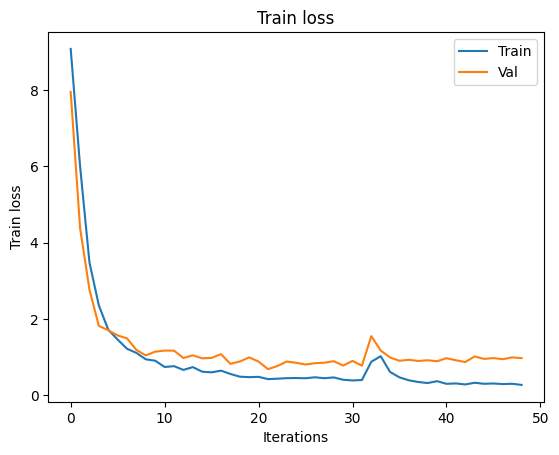

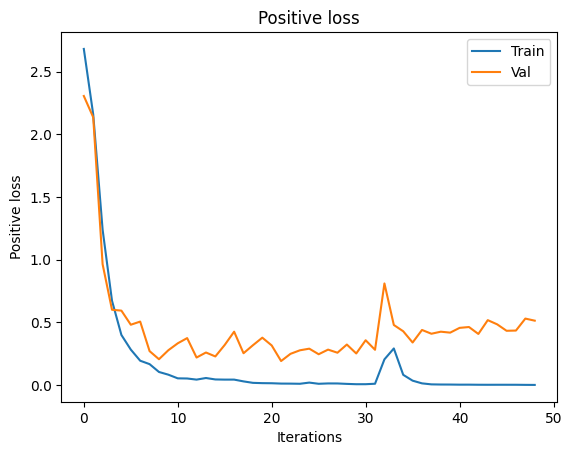

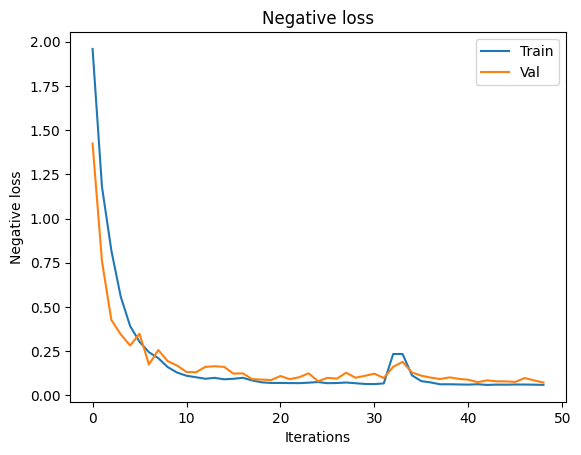

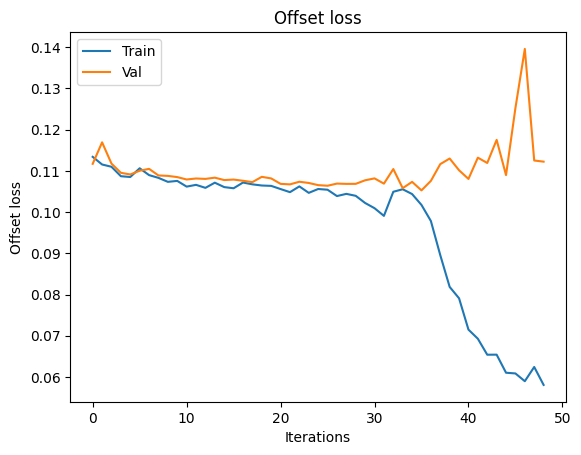

In [50]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [51]:
classes

['parcel']

In [52]:
best_loss

0.6863579353872036

# Show predictions

In [44]:
model.load_state_dict(torch.load(f"centernet-xml-seg-box-{name}.pth"))
model.eval()

centernet(
  (base_model): FeatureListNet(
    (stem_0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)


traced_model = torch.jit.trace(model, [img[None].cuda()])

torch.jit.save(traced_model, f"traced_centernet-barcode-{name}.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


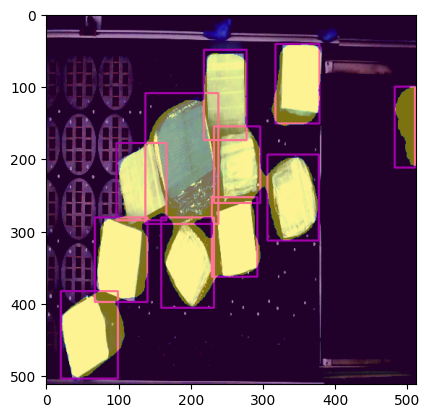

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


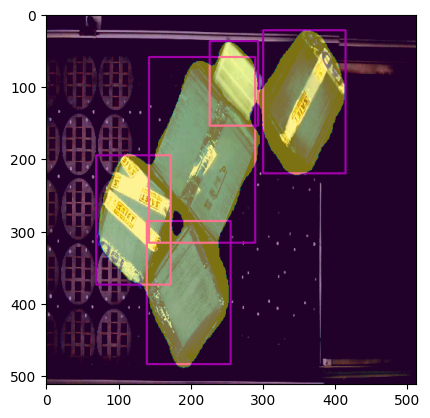

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


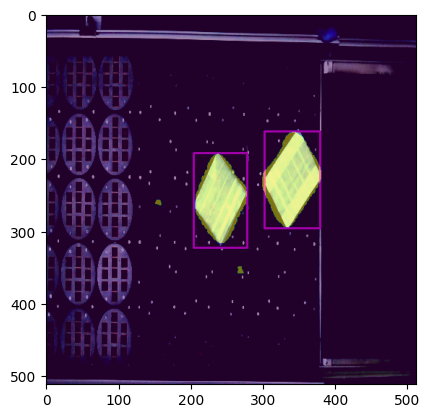

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


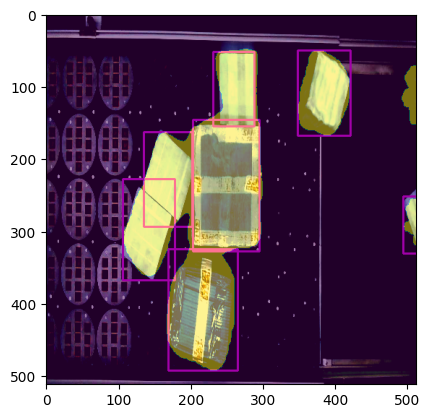

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


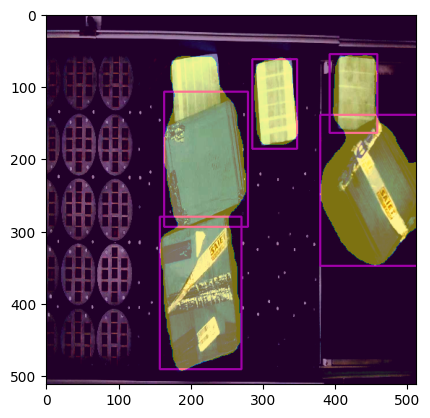

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


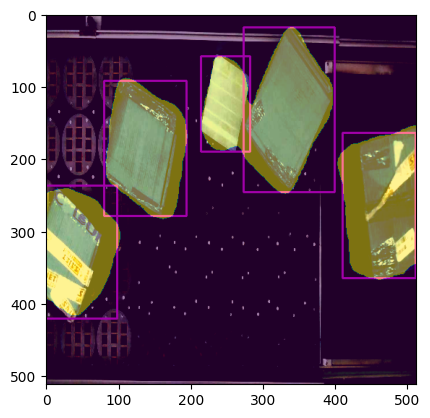

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


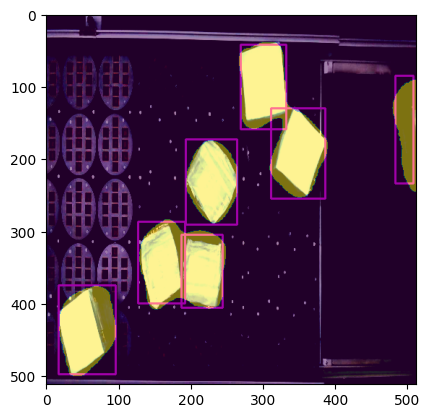

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


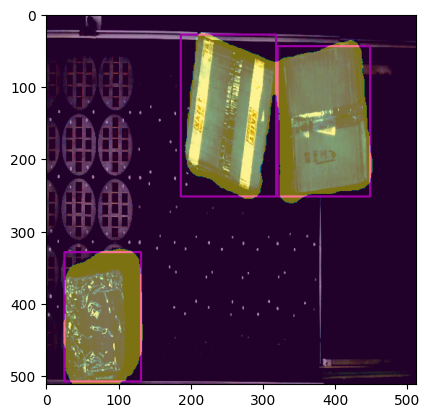

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


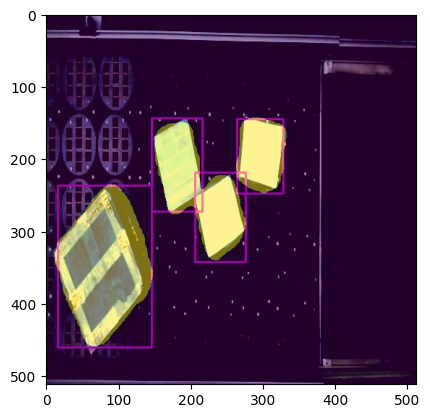

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


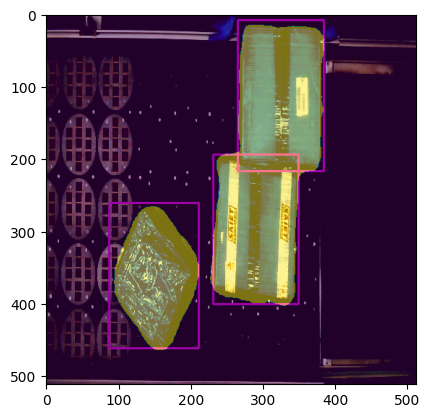

In [53]:
for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all,mask = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh,predmask = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(hm)
    outputs = decode_bbox(hm,torch.tensor(wh[None]).cuda(),torch.tensor(offset[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    try:
        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]
        for box in top_boxes:
            ymin = box[0]
            xmin = box[1] 
            ymax = box[2] 
            xmax = box[3] 

            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)

            cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    except:
        pass

    mask_output = torch.sigmoid(predmask)[0][0].cpu().numpy() 
    mask_output = cv2.resize(mask_output,(512,512))
    plt.imshow(sample)
    plt.imshow(mask_output > 0.3 ,alpha=0.5)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 41.95555556 316.4        152.17777778 382.4       ]
 [ 56.88888889 222.4        173.51111111 276.4       ]
 [104.53333333 482.4        217.6        512.4       ]
 [113.06666667 148.4        294.4        240.4       ]
 [162.84444444 239.6        263.82222222 293.6       ]
 [178.48888889 100.4        292.26666667 165.6       ]
 [196.26666667 308.4        310.04444444 375.6       ]
 [258.84444444 234.         366.93333333 294.4       ]
 [283.73333333  70.4        398.93333333 145.6       ]
 [285.15555556 166.4        406.04444444 237.6       ]
 [386.84444444  22.         505.6        109.6       ]]


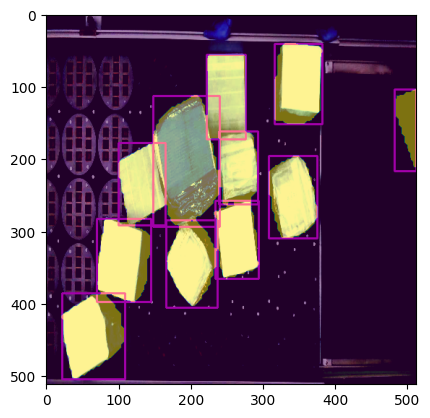

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 34.84444444 230.4        148.62222222 301.6       ]
 [ 18.48888889 296.4        226.84444444 416.4       ]
 [ 64.71111111 146.4        322.84444444 292.4       ]
 [194.84444444  69.6        381.15555556 180.4       ]
 [285.15555556 141.6        497.06666667 256.4       ]]


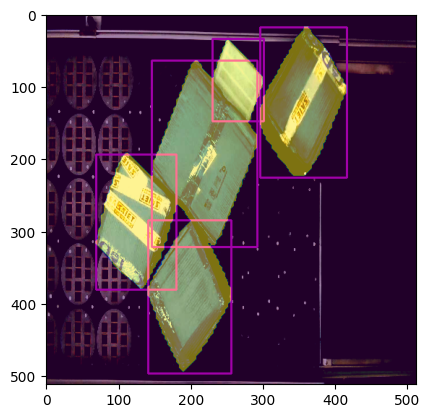

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[159.28888889 301.6        299.37777778 381.6       ]
 [192.71111111 204.4        322.84444444 277.6       ]]


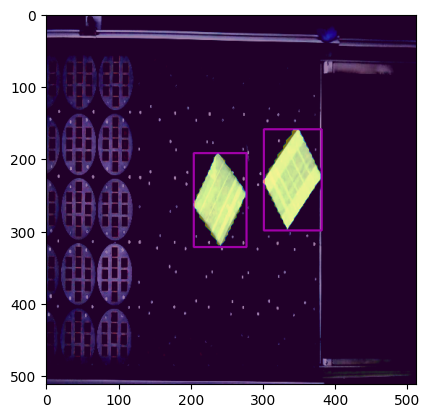

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 56.17777778 240.8        155.73333333 290.4       ]
 [ 49.06666667 347.6        169.95555556 421.6       ]
 [ 79.64444444 491.6        166.4        512.4       ]
 [160.71111111 134.4        287.28888889 202.4       ]
 [153.6        201.6        324.26666667 296.4       ]
 [243.2        490.4        333.51111111 512.4       ]
 [241.06666667 104.4        369.06666667 174.4       ]
 [322.84444444 171.6        491.37777778 260.4       ]]


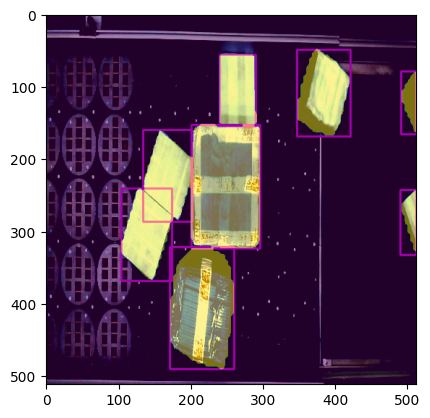

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 56.17777778 173.6        150.04444444 242.4       ]
 [ 57.6        400.4        160.71111111 455.6       ]
 [ 61.86666667 288.4        184.88888889 347.6       ]
 [118.04444444 162.4        297.95555556 276.4       ]
 [146.48888889 374.4        351.28888889 512.4       ]
 [276.62222222 160.4        497.06666667 270.4       ]]


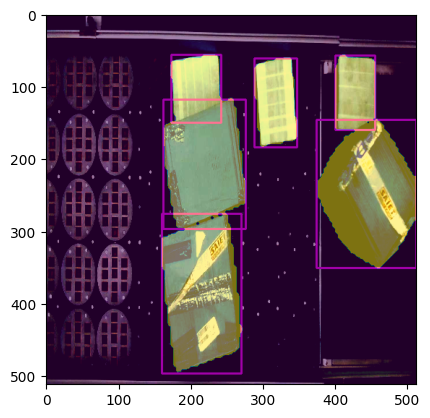

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[5.61777778e+01 2.14400000e+02 1.94844444e+02 2.82400000e+02]
 [1.49333333e+01 2.70400000e+02 2.46044444e+02 3.98400000e+02]
 [8.96000000e+01 8.04000000e+01 2.85155556e+02 1.93600000e+02]
 [1.57155556e+02 4.07600000e+02 3.69066667e+02 5.12400000e+02]
 [2.41066667e+02 4.00000000e-01 4.27377778e+02 1.10400000e+02]]


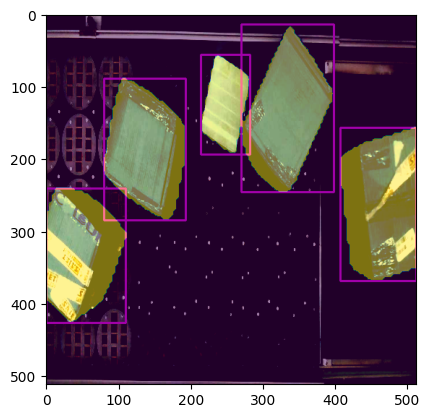

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 39.82222222 269.6        160.71111111 333.6       ]
 [ 96.         478.4        237.51111111 512.4       ]
 [128.71111111 312.4        255.28888889 388.4       ]
 [173.51111111 194.4        292.26666667 265.6       ]
 [285.15555556 131.6        409.6        189.6       ]
 [302.93333333 190.4        406.04444444 247.6       ]
 [376.17777778  16.4        500.62222222  96.4       ]]


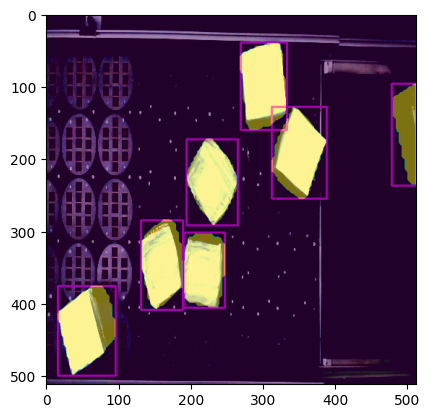

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 27.73333333 191.6        258.84444444 316.4       ]
 [ 41.95555556 314.4        263.82222222 448.4       ]
 [326.4         24.4        511.28888889 133.6       ]]


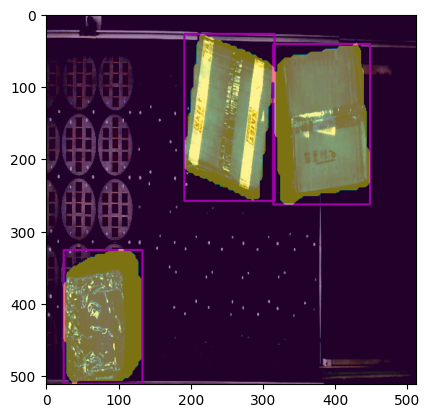

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[139.37777778 265.6        248.17777778 329.6       ]
 [145.06666667 149.6        276.62222222 216.4       ]
 [223.28888889 206.4        338.48888889 275.6       ]
 [242.48888889  12.4        470.04444444 148.4       ]]


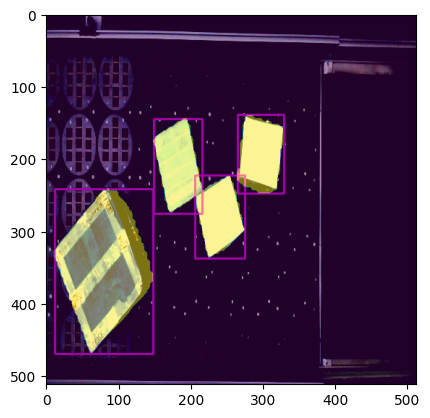

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[ 17.06666667 268.4        217.6        380.4       ]
 [192.71111111 233.6        401.06666667 347.6       ]
 [263.82222222  93.6        468.62222222 215.6       ]]


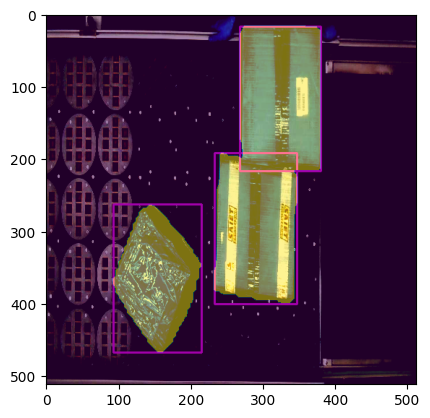

In [56]:
"""
Ground Truth of Validation

"""

for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all,mask = valdataset[id]
    sample = np.transpose(img,(1,2,0)).copy()
    print(sample.shape)
    image_shape = np.array(np.shape(img)[0:2])
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh , corner = model(img.to(device).float().unsqueeze(0))
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    hm = torch.tensor(hm_gt)
    outputs = decode_bbox(hm[None].cuda(),torch.tensor(regr_gt[None]).cuda(),torch.tensor(offset_gt[None]).cuda())
    results = postprocess(outputs,True,[512, 512],image_shape, False, 0.3)
    top_label   = np.array(results[0][:, 5], dtype = 'int32')
    top_conf    = results[0][:, 4]
    top_boxes   = results[0][:, :4]
    print(top_boxes)
    for box in top_boxes:
        ymin = box[0]
        xmin = box[1] 
        ymax = box[2] 
        xmax = box[3] 

        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)

        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,0,255),2)
    #mask_output = torch.sigmoid(predmask)[0][0].cpu().numpy() 
    mask_output = cv2.resize(mask,(512,512))
    plt.imshow(sample)
    plt.imshow(mask_output > 0.6 ,alpha=0.5)
    plt.show()